<a href="https://colab.research.google.com/github/poonsnote/NLP/blob/main/Transformer(Translation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import matplotlib.pyplot as plt
import argparse
import os
import random
import math
import tensorflow as tf
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
import nltk.translate.bleu_score

import warnings
import io
warnings.filterwarnings(action='ignore')



In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm

In [158]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
random.shuffle(lines)
lines = lines[:(int(len(lines)*0.9))]
test_lines = lines[(int(len(lines)*0.9)):]

In [159]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

SRC_LANGUAGE = 'es'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='es_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 1, TGT_LANGUAGE: 0}

    for data_sample in data_iter:
        yield token_transform[language](data_sample.split('\t')[language_index[language]])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(lines, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [160]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class VanillaTransformer(nn.Module):
    def __init__(self,num_encoder_layers,num_decoder_layers,emb_size,nhead,src_vocab_size,tgt_vocab_size,dim_feedforward = 512,dropout = 0.1):
        super(VanillaTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size,nhead=nhead,num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,dim_feedforward=dim_feedforward,dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,src,trg,src_mask,tgt_mask,src_padding_mask,tgt_padding_mask,memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory,tgt_mask)

In [161]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [162]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 256
NHEAD = 4
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

transformer = VanillaTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [163]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

In [164]:
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for data in batch:
      src_batch.append(text_transform[SRC_LANGUAGE](data.split('\t')[1]))
      tgt_batch.append(text_transform[TGT_LANGUAGE](data.split('\t')[0]))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [165]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    
    train_dataloader = DataLoader(lines, batch_size=BATCH_SIZE,collate_fn = collate_fn)

    for src,tgt in train_dataloader:
      src = src.to(DEVICE)
      tgt = tgt.to(DEVICE)
      tgt_input = tgt[:-1, :]
      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
      logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
      optimizer.zero_grad()
      tgt_out = tgt[1:, :]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()
      optimizer.step()
      losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_dataloader = DataLoader(test_lines, batch_size=BATCH_SIZE,collate_fn = collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [166]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 4.844, Val loss: 3.390, Epoch time = 27.791s
Epoch: 2, Train loss: 3.148, Val loss: 2.535, Epoch time = 27.785s
Epoch: 3, Train loss: 2.531, Val loss: 2.013, Epoch time = 27.699s
Epoch: 4, Train loss: 2.116, Val loss: 1.664, Epoch time = 27.968s
Epoch: 5, Train loss: 1.826, Val loss: 1.426, Epoch time = 28.451s
Epoch: 6, Train loss: 1.614, Val loss: 1.246, Epoch time = 28.937s
Epoch: 7, Train loss: 1.451, Val loss: 1.108, Epoch time = 29.615s
Epoch: 8, Train loss: 1.320, Val loss: 0.991, Epoch time = 28.654s
Epoch: 9, Train loss: 1.213, Val loss: 0.899, Epoch time = 28.901s
Epoch: 10, Train loss: 1.124, Val loss: 0.820, Epoch time = 28.409s


In [167]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

In [168]:
def translate(model, src_sentence):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [169]:
src_test = [x.split('\t')[1] for x in test_lines]
tgt_test = [x.split('\t')[0] for x in test_lines]

en_length = []
bleu_list = []
for i in tqdm(range(len(src_test))):
  src_sentence = src_test[i]
  tgt_sentence = tgt_test[i]
  result = translate(transformer, src_sentence)
  if i%300==1:
    print('en :', tgt_sentence)
    print('pred :', result)
  bleu_score = nltk.translate.bleu_score.sentence_bleu([tgt_sentence], result, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
  en_length.append(len(tgt_sentence.split(' ')))
  bleu_list.append(bleu_score)

Transformer_df = pd.DataFrame([en_length,bleu_list]).T

en : I'm sorry I cannot go with you.
pred :  I 'm sorry , I ca n't go with you . 
en : She isn't married.
pred :  She is not married . 
en : I studied before supper.
pred :  I studied before dinner . 
en : Tom is a tough guy.
pred :  Tom is a hard guy . 
en : You may use my car.
pred :  You can use my car . 
en : Answer me.
pred :  Give me it . 
en : He won't believe it.
pred :  He wo n't believe it . 
en : Tom didn't even offer Mary a cup of coffee.
pred :  Tom does n't even give Mary a cup of coffee . 
en : We arrived here at six yesterday evening.
pred :  We arrived here at six afternoon yesterday . 
en : Tom was late for work again this morning.
pred :  Tom will come late for work this morning . 
en : He teaches English to his friend.
pred :  He teaches English to his friend . 
en : He drove to school.
pred :  He drove to school . 
en : Give us a hand.
pred :  Give us a call . 
en : The water is good.
pred :  The water is good . 
en : Tom didn't want to do it.
pred :  Tom did n't w

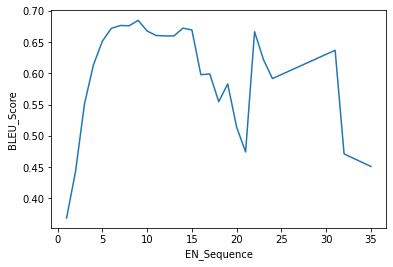

In [170]:
plt.plot(Transformer_df.groupby(0)[1].mean(),label='Transformer')
plt.xlabel("EN_Sequence")
plt.ylabel("BLEU_Score")
plt.show()